# Step 1: Merge Data

In [19]:
import pandas as pd

# Paths to the files are given by the user
calendar_files = {
    '2022_09': '2022_09_calendar.csv',
    '2022_12': '2022_12_calendar.csv',
    '2023_03': '2023_03_calendar.csv',
    '2023_06': '2023_06_calendar.csv',
    '2023_09': '2023_09_calendar.csv',
}

listings_files = {
    '2022_09': '2022_09_listings.csv',
    '2022_12': '2022_12_listings.csv',
    '2023_03': '2023_03_listings.csv',
    '2023_06': '2023_06_listings.csv',
    '2023_09': '2023_09_listings.csv',
}

# Initialize an empty DataFrame to hold the merged data
merged_data = pd.DataFrame()

for period in calendar_files:
    calendar_path = calendar_files[period]
    listings_path = listings_files[period]

    # Read the calendar and listings data
    calendar_df = pd.read_csv(calendar_path)
    listings_df = pd.read_csv(listings_path)

    # Convert 'date' in calendar_df to datetime and ensure IDs are of the same type
    calendar_df['date'] = pd.to_datetime(calendar_df['date']).dt.date
    calendar_df['listing_id'] = calendar_df['listing_id'].astype(str)
    listings_df['id'] = listings_df['id'].astype(str)

    # Create a 'price_listing' column in listings data
    listings_df['price_listing'] = listings_df['price']
    listings_df['minimum_nights_listing'] = listings_df['minimum_nights']
    listings_df['maximum_nights_listing'] = listings_df['maximum_nights']

    # Keep only necessary columns from calendar and listings data
    calendar_df = calendar_df[['listing_id', 'date', 'available', 'price', 'minimum_nights', 'maximum_nights']]
    listings_columns_to_keep = ['id', 'price_listing', 'minimum_nights_listing', 'maximum_nights_listing', 'host_since', 'host_verifications',                             'host_acceptance_rate', 'host_is_superhost','neighbourhood_cleansed', 'property_type', 'room_type', 'accommodates', 
                                'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'license', 'number_of_reviews', 'number_of_reviews_l30d', 
                                'review_scores_rating', 'availability_30', 'availability_60', 'availability_90', 'availability_365', 
                                'instant_bookable', 'calculated_host_listings_count','host_response_time','host_response_rate']
    listings_df = listings_df[listings_columns_to_keep]

    # Find missing IDs and their date range
    missing_ids = set(listings_df['id']) - set(calendar_df['listing_id'])
    date_range = pd.date_range(start=calendar_df['date'].min(), end=calendar_df['date'].max())

    # For each missing ID, create new rows
    for missing_id in missing_ids:
        listing_details = listings_df[listings_df['id'] == missing_id]
        missing_rows = pd.DataFrame({
            'listing_id': missing_id,
            'date': date_range,
            'available': 'f',
            'price': listing_details['price_listing'].values[0],
            'minimum_nights': listing_details['minimum_nights_listing'].values[0],
            'maximum_nights': listing_details['maximum_nights_listing'].values[0]
        })
        calendar_df = pd.concat([calendar_df, missing_rows], ignore_index=True)

 # Merge calendar data with the corresponding listings data
    period_merged_data = calendar_df.merge(listings_df, how='left', left_on='listing_id', right_on='id')

 # Append the period data to the full merged dataset
    merged_data = pd.concat([merged_data, period_merged_data], ignore_index=True)

# Drop duplicates, if any
merged_data.drop_duplicates(subset=['listing_id', 'date'], keep='last', inplace=True)

# Handle missing values
merged_data.fillna(method='ffill', inplace=True)

# Save the cleaned, merged data to a new CSV file
output_file = 'merged_cleaned_data.csv'
merged_data.to_csv(output_file, index=False)

print(f"Processed data saved to {output_file}")

Processed data saved to merged_cleaned_data.csv


# Data Cleaning Procedures

In [170]:
import pandas as pd

def percent_to_float(s):
    """Convert percentage string to float."""
    try:
        return float(s.strip('%')) / 100
    except AttributeError:
        return None

# Load the dataset
file_path = 'merged_cleaned_data.csv'  # Replace with your actual file path
data = pd.read_csv(file_path)

# Apply the conversion functions to other columns as needed
data['host_response_rate'] = data['host_response_rate'].apply(percent_to_float)
data['price'] = data['price'].replace('[\$,]', '', regex=True).astype(float)

# Convert 'bathrooms_text' to numerical and 'amenities' to count
data['bathrooms'] = data['bathrooms_text'].str.extract('(\d+)').astype(float)
data['amenities_count'] = data['amenities'].str.count(',') + 1

# Convert specific columns to binary (0 or 1)
data['host_is_superhost'] = (data['host_is_superhost'] == 't').astype(int)
data['license'] = data['license'].notna().astype(int)
data['instant_bookable'] = (data['instant_bookable'] == 't').astype(int)

# Categorize property_type
def categorize_property_type(pt):
    if 'Private' in pt:
        return 'Private'
    elif 'Entire' in pt:
        return 'Entire'
    elif 'Shared' in pt:
        return 'Shared_room'
    elif 'hotel' in pt:
        return 'hotel'
    else:
        return 'Other'

data['property_type_category'] = data['property_type'].apply(categorize_property_type)

# Create dummy variables for the new property_type categories
property_type_dummies = pd.get_dummies(data['property_type_category'], prefix='property_type')

# Concatenate the dummy variables with the original DataFrame
data = pd.concat([data, property_type_dummies], axis=1)

# Drop the original property_type column and the new categorical column
data.drop(['property_type'], axis=1, inplace=True)

# Create dummy variables for other categorical columns
categorical_cols = ['host_response_time', 'host_verifications', 'neighbourhood_cleansed', 'property_type_category', 'room_type']
data = pd.get_dummies(data, columns=categorical_cols, drop_first=True, dummy_na=True)

# Ensure numerical columns are in correct format
numerical_cols = ['minimum_nights', 'maximum_nights', 'price_listing',
                  'minimum_nights_listing', 'maximum_nights_listing','accommodates',
                  'bedrooms', 'beds', 'calculated_host_listings_count',
                  'number_of_reviews', 'number_of_reviews_l30d', 
                  'review_scores_rating', 'availability_30', 'availability_60',
                  'availability_90', 'availability_365', 'amenities_count']
data[numerical_cols] = data[numerical_cols].apply(pd.to_numeric, errors='coerce')

# Check if 'available' exists, and create a dummy if it does
if 'available' in data.columns:
    data['available_dummy'] = data['available'].apply(lambda x: 1 if x == 't' else 0)

# Fill missing values for numerical columns with mean
for col in numerical_cols:
    data[col].fillna(data[col].mean(), inplace=True)

# Drop unnecessary columns
columns_to_drop = ['bathrooms_text', 'amenities']
data.drop(columns=columns_to_drop, inplace=True)

# Save the cleaned data
cleaned_data_path = 'cleaned_merged_data.csv'
data.to_csv(cleaned_data_path, index=False)

cleaned_data_path


'cleaned_merged_data.csv'

In [171]:
# Generate a summary table
summary_table = data.describe(include='all')

summary_table


,listing_id,date,available,price,minimum_nights,maximum_nights,id,price_listing,minimum_nights_listing,maximum_nights_listing,...,property_type_category_Other,property_type_category_Private,property_type_category_Shared_room,property_type_category_hotel,property_type_category_nan,room_type_Hotel room,room_type_Private room,room_type_Shared room,room_type_nan,available_dummy
count,3.864359e+06,3864359,3864359,3.864359e+06,3.864359e+06,3.864359e+06,3.864359e+06,0.0,3.864359e+06,3.864359e+06,...,3.864359e+06,3.864359e+06,3.864359e+06,3.864359e+06,3864359.0,3.864359e+06,3.864359e+06,3.864359e+06,3864359.0,3.864359e+06
unique,NaN,1282,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,2023-08-29,t,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,6696,2014630,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2.614182e+17,NaN,NaN,2.377738e+02,6.508906e+01,2.483183e+06,2.614182e+17,NaN,2.919783e+01,6.560941e+02,...,2.174746e-03,3.284048e-01,4.460248e-03,2.196716e-02,0.0,5.423668e-03,3.448316e-01,4.460248e-03,0.0,5.213361e-01
std,3.576345e+17,NaN,NaN,3.495252e+02,1.348942e+02,7.297059e+07,3.576345e+17,NaN,3.834250e+01,5.507694e+02,...,4.658344e-02,4.696330e-01,6.663599e-02,1.465763e-01,0.0,7.344558e-02,4.753134e-01,6.663599e-02,0.0,4.995446e-01
min,3.168000e+03,NaN,NaN,0.000000e+00,1.000000e+00,1.000000e+00,3.168000e+03,NaN,1.000000e+00,1.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
25%,2.541631e+07,NaN,NaN,9.800000e+01,2.000000e+00,3.650000e+02,2.541631e+07,NaN,2.000000e+00,3.600000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00
50%,4.860119e+07,NaN,NaN,1.740000e+02,2.100000e+01,1.125000e+03,4.860119e+07,NaN,1.400000e+01,3.650000e+02,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.0,1.000000e+00
75%,6.522855e+17,NaN,NaN,2.780000e+02,9.100000e+01,1.125000e+03,6.522855e+17,NaN,3.200000e+01,1.125000e+03,...,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,1.000000e+00,0.000000e+00,0.0,1.000000e+00


C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\2571097053.py:29: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available_dummy'] == 1], x='date', y='price', label='Treatment', ci=None)
C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\2571097053.py:32: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available_dummy'] == 0], x='date', y='price', label='Control', ci=None)


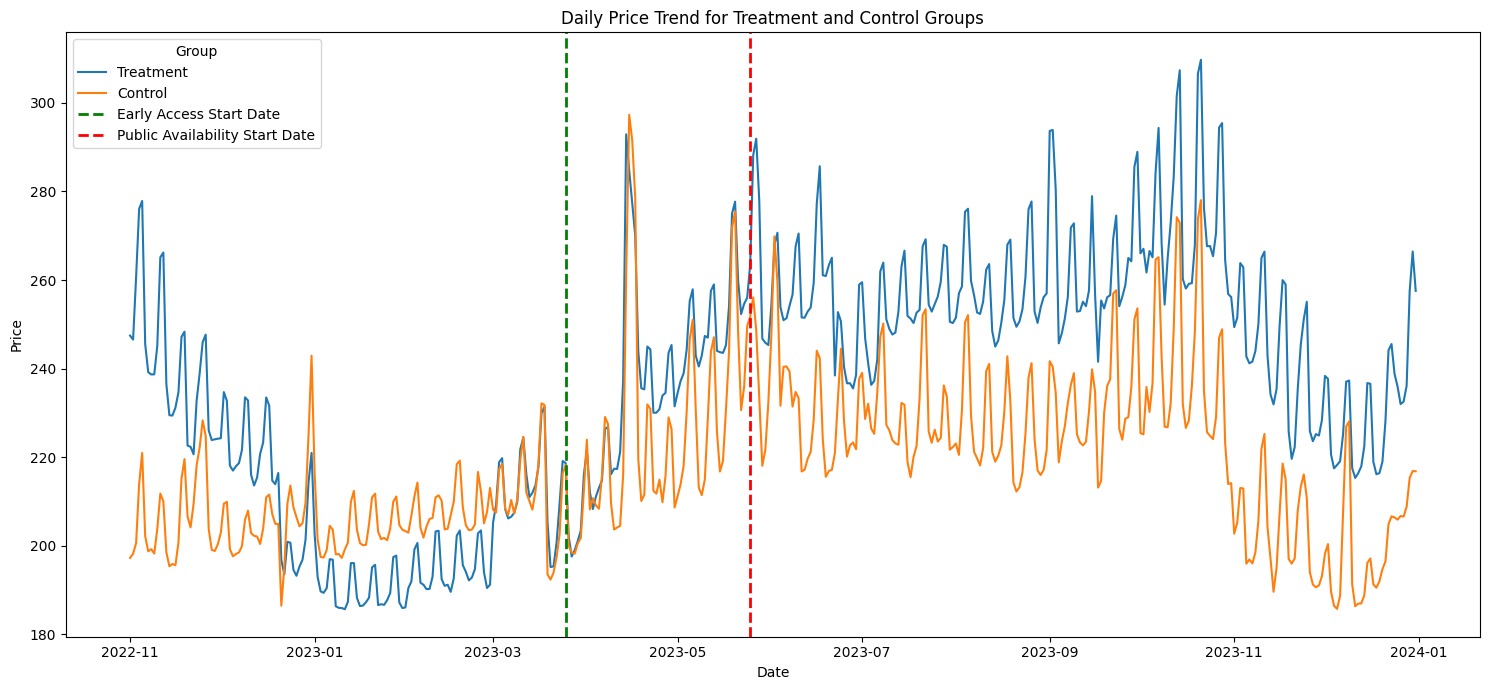

In [172]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
data = pd.read_csv('cleaned_merged_data.csv')  # Replace with the actual path to your data

# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])

# Define the date range for plotting
start_date = '2022-11-01'  # Start of your data
end_date = '2023-12-31'  # End of the date range you want to plo

# Filter data for the date range
data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Define cutoff dates for the introduction of the Smart Pricing tool
early_access_start = pd.to_datetime('2023-03-25')
public_availability_start = pd.to_datetime('2023-05-25')

# Create a binary variable for post-policy based on the early_access_start date
data['post_policy'] = (data['date'] >= early_access_start).astype(int)

# Plotting
plt.figure(figsize=(15, 7))

# Treatment group plot
sns.lineplot(data=data[data['available_dummy'] == 1], x='date', y='price', label='Treatment', ci=None)

# Control group plot
sns.lineplot(data=data[data['available_dummy'] == 0], x='date', y='price', label='Control', ci=None)

# Highlight the policy change dates
plt.axvline(x=pd.to_datetime('2023-03-25'), color='green', linestyle='--', lw=2, label='Early Access Start Date')
plt.axvline(x=pd.to_datetime('2023-05-25'), color='red', linestyle='--', lw=2, label='Public Availability Start Date')

# Improve the legend
plt.legend(title='Group', loc='upper left')

# Title and labels
plt.title('Daily Price Trend for Treatment and Control Groups')
plt.xlabel('Date')
plt.ylabel('Price')

# Tight layout for saving
plt.tight_layout()

# Show plot
plt.show()

C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\3851665242.py:11: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available_dummy'] == 1], x='date', y='price_smoothed', label='Treatment', ci=None)
C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\3851665242.py:14: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(data=data[data['available_dummy'] == 0], x='date', y='price_smoothed', label='Control', ci=None)


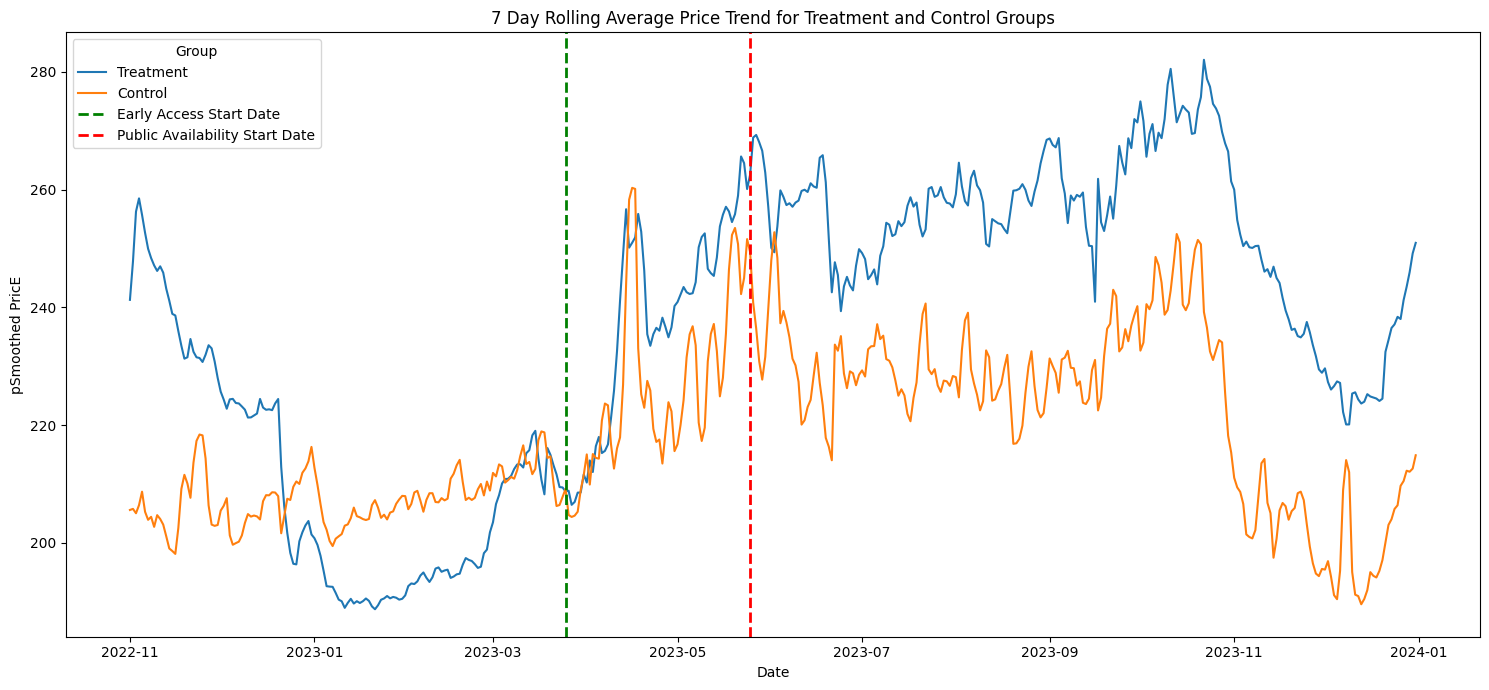

In [173]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data['price_smoothed'] = data.groupby('available_dummy')['price'].transform(lambda x: x.rolling(7, center=True).mean())

# Plotting
plt.figure(figsize=(15, 7))

# Treatment group plot
sns.lineplot(data=data[data['available_dummy'] == 1], x='date', y='price_smoothed', label='Treatment', ci=None)

# Control group plot
sns.lineplot(data=data[data['available_dummy'] == 0], x='date', y='price_smoothed', label='Control', ci=None)

# Highlight the policy change dates
plt.axvline(x=pd.to_datetime('2023-03-25'), color='green', linestyle='--', lw=2, label='Early Access Start Date')
plt.axvline(x=pd.to_datetime('2023-05-25'), color='red', linestyle='--', lw=2, label='Public Availability Start Date')

# Improve the legend
plt.legend(title='Group', loc='upper left')

# Title and labels
plt.title('7 Day Rolling Average Price Trend for Treatment and Control Groups')
plt.xlabel('Date')
plt.ylabel('pSmoothed PricE')

# Tight layout for saving
plt.tight_layout()

# Show plot
plt.show()


### IVs should have the following characteristics:

* Strongly correlated with available_dummy (the treatment variable).
* Not correlated or very weakly correlated with the price (the outcome variable), which is not shown in this correlation matrix but is necessary to check.

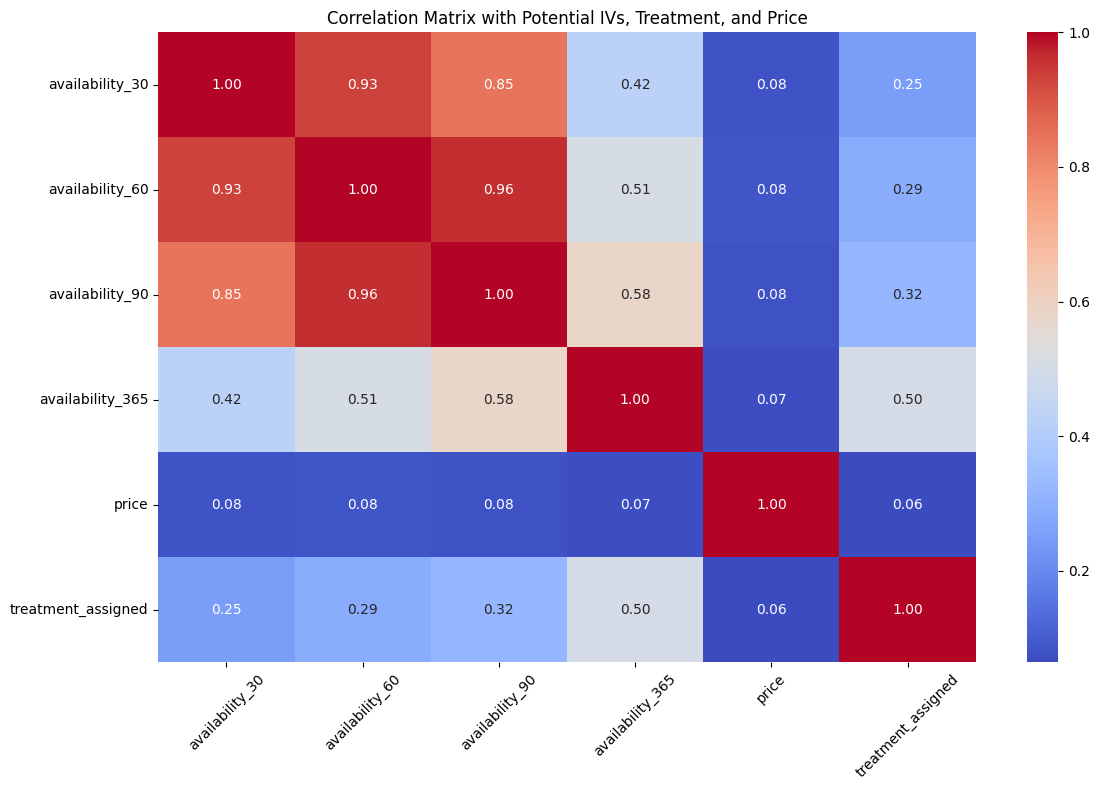

In [174]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce
from tqdm import tqdm

# Load the dataset
file_path = 'cleaned_merged_data.csv'
data = pd.read_csv(file_path)

# Convert date to datetime and sort the dataframe
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Replace spaces with underscores in categorical column names to avoid spaces in dummy variable names
data.columns = data.columns.str.replace(' ', '_')

# Identify categorical columns and apply binary encoding
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
encoder = ce.BinaryEncoder(cols=categorical_cols)
data_encoded = encoder.fit_transform(data[categorical_cols])

# Concatenate the encoded columns with original data
data = pd.concat([data.drop(categorical_cols, axis=1), data_encoded], axis=1)

# Define cutoff date and create treatment assignment
cutoff_date = pd.to_datetime('2023-03-25')
data['days_from_cutoff'] = (data['date'] - cutoff_date).dt.days
data['treatment_assigned'] = ((data['available_dummy'] == 1) & (data['date'] >= cutoff_date)).astype(int)

# Exclude non-relevant variables from the correlation matrix
excluded_vars = ['days_from_cutoff', 'listing_id', 'id', 'price_listing', 'minimum_nights_listing', 
                 'maximum_nights_listing', 'available_dummy', 'available_0', 'available_1']
all_cols = data.columns.tolist()
relevant_cols = [col for col in all_cols if col not in excluded_vars]

# Calculate the correlation matrix
corr_matrix = data[relevant_cols].corr()

# Define thresholds and identify potential IVs
corr_with_treatment_threshold = 0.2 # Min
corr_with_price_threshold = 0.1 # Max
potential_ivs = [col for col in corr_matrix.columns if (col != 'treatment_assigned') and (abs(corr_matrix.loc[col, 'treatment_assigned']) > corr_with_treatment_threshold) and (abs(corr_matrix.loc[col, 'price']) < corr_with_price_threshold)]

# Plot the final correlation matrix heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix.loc[potential_ivs + ['price', 'treatment_assigned'], potential_ivs + ['price', 'treatment_assigned']], annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix with Potential IVs, Treatment, and Price")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [176]:
print(potential_ivs)

['availability_30', 'availability_60', 'availability_90', 'availability_365']


In [177]:
ivs = ['availability_30', 'availability_60', 'availability_90', 'availability_365']

Variables with high correlation to 'available_dummy': ['host_is_superhost', 'instant_bookable', 'calculated_host_listings_count', 'host_response_time_within_a_day', 'neighbourhood_cleansed_Chinatown', 'neighbourhood_cleansed_Dorchester', 'host_since_3', 'host_since_7']


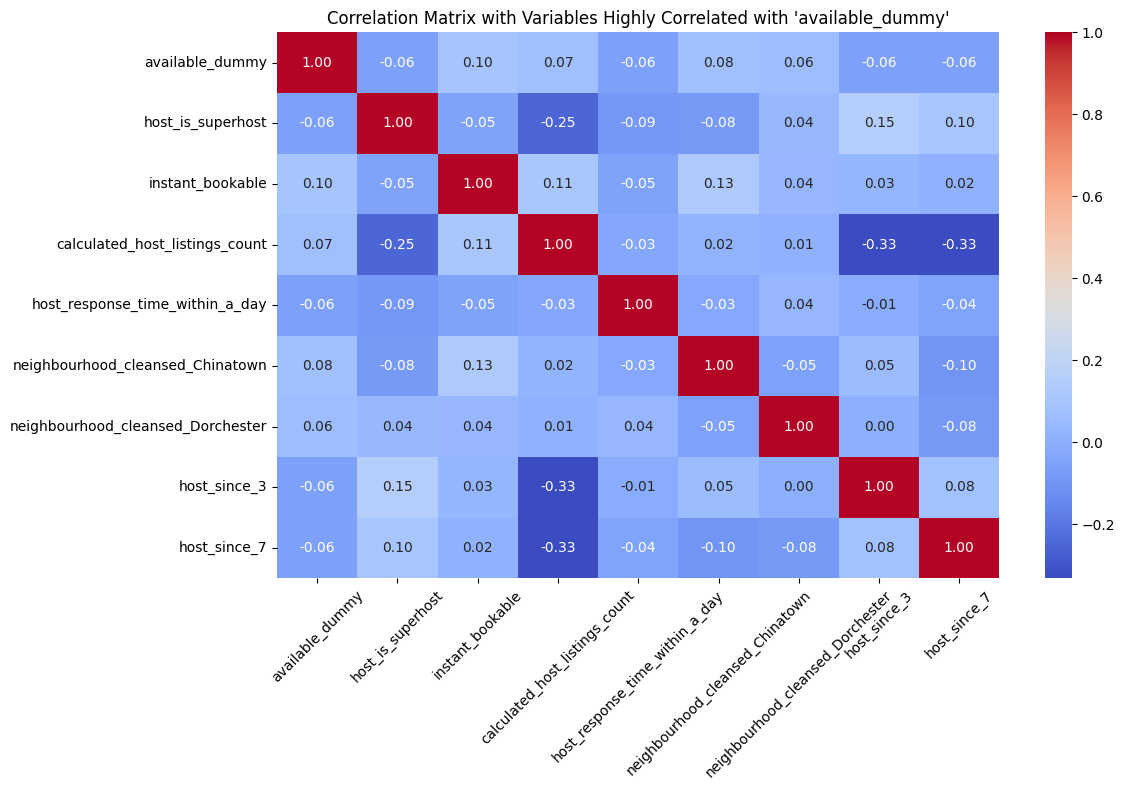

In [178]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

# Load the dataset
file_path = 'cleaned_merged_data.csv'
data = pd.read_csv(file_path)

# Convert date to datetime and sort the dataframe
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Replace spaces with underscores in column names
data.columns = data.columns.str.replace(' ', '_')

# Identify categorical columns and apply binary encoding
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
encoder = ce.BinaryEncoder(cols=categorical_cols)
data_encoded = encoder.fit_transform(data[categorical_cols])

# Concatenate the encoded columns with original data
data = pd.concat([data.drop(categorical_cols, axis=1), data_encoded], axis=1)

# Define the list of variables to exclude from the correlation analysis
excluded_vars = ['days_from_cutoff', 'listing_id', 'id', 'price_listing', 
                 'minimum_nights_listing', 'maximum_nights_listing', 
                 'available_dummy', 'available_0', 'available_1']
excluded_vars = excluded_vars + potential_ivs

# Initialize a list to store variables with high correlation
control_vars_1st = []

# Define the correlation threshold
corr_threshold = 0.05

# Calculate correlations for each numeric variable in the DataFrame
for var in data.columns:
    if var in excluded_vars or not pd.api.types.is_numeric_dtype(data[var]):
        continue
    corr_with_available = data['available_dummy'].corr(data[var])
    if abs(corr_with_available) >= corr_threshold:
        control_vars_1st.append(var)

# Display the list of variables with high correlation
print("Variables with high correlation to 'available_dummy':", control_vars_1st)

# Calculate and plot the final correlation matrix for the selected high correlation variables
final_corr_matrix = data[['available_dummy'] + control_vars_1st].corr()

# Plot the final heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(final_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix with Variables Highly Correlated with 'available_dummy'")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [180]:
print(control_vars_1st)

['host_is_superhost', 'instant_bookable', 'calculated_host_listings_count', 'host_response_time_within_a_day', 'neighbourhood_cleansed_Chinatown', 'neighbourhood_cleansed_Dorchester', 'host_since_3', 'host_since_7']


In [181]:
control_vars_1st = ['host_is_superhost',
 'instant_bookable',
 'calculated_host_listings_count',
 'host_response_time_within_a_day',
 'host_response_time_within_a_day',
 'host_response_time_within_a_few_hours',
 'host_response_time_within_an_hour',
 'host_response_time_nan',
 'host_since_1',
 'host_since_2',
 'host_since_3',
 'host_since_4',
 'host_since_5',
 'host_since_6',
 'host_since_7',
 'host_since_8',
 'host_since_9',
 'host_since_10']

In [185]:
my_list = data.columns.values.tolist()
my_list

['listing_id',
 'date',
 'price',
 'minimum_nights',
 'maximum_nights',
 'id',
 'price_listing',
 'minimum_nights_listing',
 'maximum_nights_listing',
 'host_is_superhost',
 'accommodates',
 'bedrooms',
 'beds',
 'license',
 'number_of_reviews',
 'number_of_reviews_l30d',
 'review_scores_rating',
 'availability_30',
 'availability_60',
 'availability_90',
 'availability_365',
 'instant_bookable',
 'calculated_host_listings_count',
 'host_response_rate',
 'bathrooms',
 'amenities_count',
 'property_type_Entire',
 'property_type_Other',
 'property_type_Private',
 'property_type_Shared_room',
 'property_type_hotel',
 'host_response_time_within_a_day',
 'host_response_time_within_a_few_hours',
 'host_response_time_within_an_hour',
 'host_response_time_nan',
 "host_verifications_['email',_'phone']",
 "host_verifications_['email']",
 "host_verifications_['phone',_'work_email']",
 "host_verifications_['phone']",
 'host_verifications_[]',
 'host_verifications_nan',
 'neighbourhood_cleansed_Bac

Variables with high correlation to 'price': ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 'property_type_Entire', 'property_type_Private', 'property_type_hotel', 'host_response_time_within_an_hour', 'neighbourhood_cleansed_Downtown', 'property_type_category_Private', 'property_type_category_hotel', 'room_type_Hotel_room', 'room_type_Private_room']


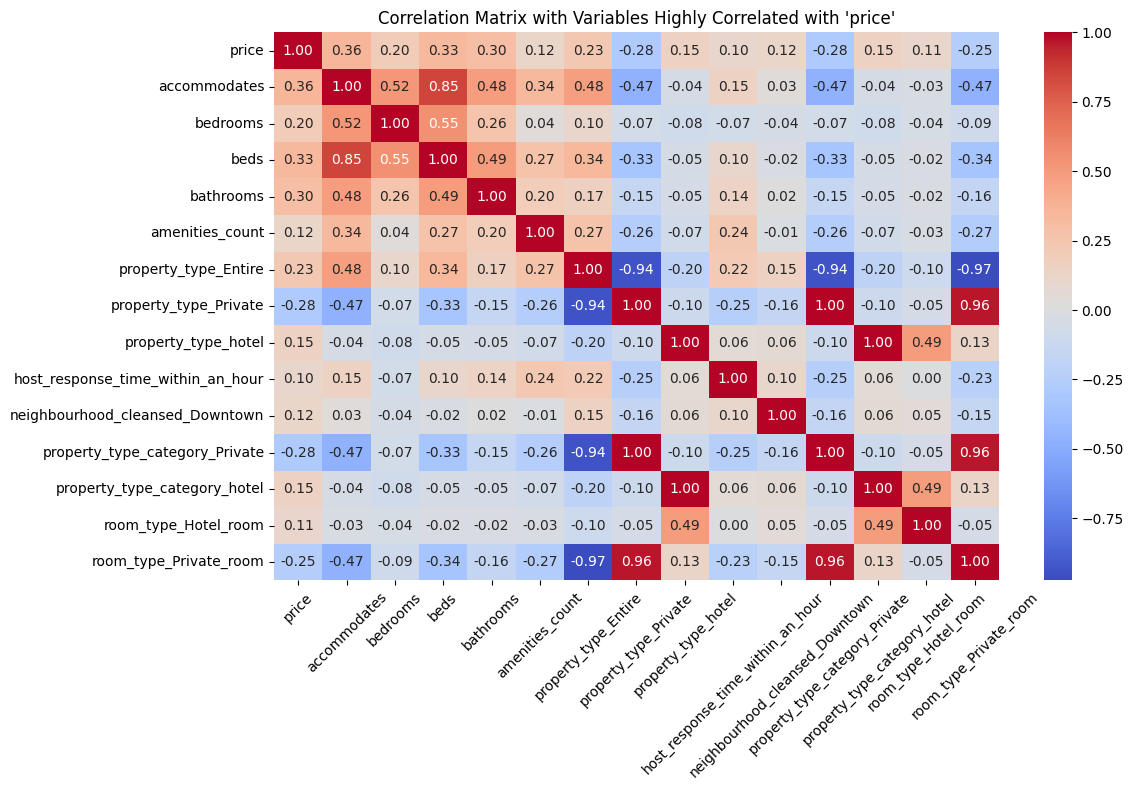

In [183]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import category_encoders as ce

# Load the dataset
file_path = 'cleaned_merged_data.csv'
data = pd.read_csv(file_path)

# Convert date to datetime and sort the dataframe
data['date'] = pd.to_datetime(data['date'])
data.sort_values('date', inplace=True)

# Replace spaces with underscores in column names
data.columns = data.columns.str.replace(' ', '_')

# Identify categorical columns and apply binary encoding
categorical_cols = data.select_dtypes(include=['object', 'category']).columns.tolist()
encoder = ce.BinaryEncoder(cols=categorical_cols)
data_encoded = encoder.fit_transform(data[categorical_cols])

# Concatenate the encoded columns with original data
data = pd.concat([data.drop(categorical_cols, axis=1), data_encoded], axis=1)

# Define the list of variables to exclude from the correlation analysis
excluded_vars = ['days_from_cutoff', 'listing_id', 'id', 'price_listing', 
                 'minimum_nights_listing', 'maximum_nights_listing', 
                 'available_dummy', 'available_0', 'available_1','price']

# Initialize a list to store variables with high correlation
control_vars_2nd = []

# Define the correlation threshold
corr_threshold = 0.10

# Calculate correlations for each numeric variable in the DataFrame
for var in data.columns:
    if var in excluded_vars or not pd.api.types.is_numeric_dtype(data[var]):
        continue
    corr_with_available = data['price'].corr(data[var])
    if abs(corr_with_available) >= corr_threshold:
        control_vars_2nd.append(var)

# Display the list of variables with high correlation
print("Variables with high correlation to 'price':", control_vars_2nd)

# Calculate and plot the final correlation matrix for the selected high correlation variables
final_corr_matrix = data[['price'] + control_vars_2nd].corr()

# Plot the final heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(final_corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title("Correlation Matrix with Variables Highly Correlated with 'price'")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [184]:
print(control_vars_2nd)

['accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 'property_type_Entire', 'property_type_Private', 'property_type_hotel', 'host_response_time_within_an_hour', 'neighbourhood_cleansed_Downtown', 'property_type_category_Private', 'property_type_category_hotel', 'room_type_Hotel_room', 'room_type_Private_room']


In [190]:
control_vars_2nd = ['accommodates', 'bedrooms', 'beds', 'bathrooms', 'amenities_count', 
                    'neighbourhood_cleansed_Back_Bay',
 'neighbourhood_cleansed_Bay_Village',
 'neighbourhood_cleansed_Beacon_Hill',
 'neighbourhood_cleansed_Brighton',
 'neighbourhood_cleansed_Charlestown',
 'neighbourhood_cleansed_Chinatown',
 'neighbourhood_cleansed_Dorchester',
 'neighbourhood_cleansed_Downtown',
 'neighbourhood_cleansed_East_Boston',
 'neighbourhood_cleansed_Fenway',
 'neighbourhood_cleansed_Harbor_Islands',
 'neighbourhood_cleansed_Hyde_Park',
 'neighbourhood_cleansed_Jamaica_Plain',
 'neighbourhood_cleansed_Leather_District',
 'neighbourhood_cleansed_Longwood_Medical_Area',
 'neighbourhood_cleansed_Mattapan',
 'neighbourhood_cleansed_Mission_Hill',
 'neighbourhood_cleansed_North_End',
 'neighbourhood_cleansed_Roslindale',
 'neighbourhood_cleansed_Roxbury',
 'neighbourhood_cleansed_South_Boston',
 'neighbourhood_cleansed_South_Boston_Waterfront',
 'neighbourhood_cleansed_South_End',
 'neighbourhood_cleansed_West_End',
 'neighbourhood_cleansed_West_Roxbury',
 'room_type_Hotel_room',
 'room_type_Private_room',
 'room_type_Shared_room',]

In [194]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define cutoff date and create treatment assignment
cutoff_date = pd.to_datetime('2023-03-25')
bandwidth = 30  # Define your bandwidth (e.g., 30 days)

# Restrict data to observations within the bandwidth around the cutoff
data['days_from_cutoff'] = (data['date'] - cutoff_date).dt.days
data_within_bandwidth = data[abs(data['days_from_cutoff']) <= bandwidth]

# Treatment assignment
data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)

# First Stage: Predict the treatment assignment using potential IVs and control variables
first_stage_vars = ['days_from_cutoff'] + ivs + control_vars_1st
first_stage_formula = 'treatment_assigned ~ 1 + ' + ' + '.join(first_stage_vars)
first_stage_model = smf.ols(formula=first_stage_formula, data=data).fit(cov_type='HC3')
data['predicted_treatment'] = first_stage_model.fittedvalues

# Second Stage: Regress the outcome on the predicted treatment and the control variables
# Ensure control_vars_2nd is defined and properly formatted
second_stage_vars = ['predicted_treatment'] + control_vars_2nd
second_stage_formula = 'price ~ 1 + ' + ' + '.join(second_stage_vars)
second_stage_model = smf.ols(formula=second_stage_formula, data=data).fit(cov_type='HC3')

# Print the summary of the regression results
print(second_stage_model.summary())

C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\3985732847.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                 3.653e+04
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:27:28   Log-Likelihood:            -2.7624e+07
No. Observations:             3861716   AIC:                         5.525e+07
Df Residuals:                 3861681   BIC:                         5.525e+07
Df Model:                          34                                         
Covariance Type:                  HC3                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

### key findings and conclusions:

1. Predicted Treatment (smart_pricing_tool): The coefficient for predicted_treatment is 77.0888 with a p-value close to 0, indicating a strong and statistically significant positive relationship with price. This suggests that the use of Airbnb's pricing tool (treatment) is associated with a significant increase in listing price.

2. Model Fit: The R-squared value is 0.209, meaning that approximately 20.9% of the variability in the price is explained by the model. This is a moderate level of explanatory power, suggesting that other factors not included in the model also significantly affect price.

3. Intercept: The intercept value of -16.0337 suggests that the baseline price (excluding the effect of all variables) is negative, which may be a sign of overfitting or multicollinearity issues, or it might reflect that certain key variables are missing from the model.

4. Other Variables:

* Accommodates, bedrooms, beds, and bathrooms show significant positive associations with price.
* Amenities count has a small negative association with price.
* Specific neighborhood (neighbourhood_cleansed_Downtown) and property types (like Entire_serviced_apartment, Room_in_hotel) have significant positive effects on price.
* Certain room types (Private_room_in_home, Private_room_in_rental_unit) are associated with lower prices, while Hotel_room significantly increases price.
5. Statistical Significance: All variables in the model are statistically significant, as indicated by their p-values.

6. Model Diagnostics: The Durbin-Watson statistic is close to 2, suggesting no autocorrelation issues. However, the Omnibus and Jarque-Bera tests indicate potential problems with the normality of residuals. The very high skewness and kurtosis values also imply that the residuals are not normally distributed, which is a key assumption of OLS regression. This may affect the reliability of the coefficient estimates and their standard errors.

#### Conclusion: The use of Airbnb’s pricing tool is associated with higher prices for listings. The model also highlights important factors influencing the price, such as accommodation capacity, property type, and location. However, the potential issues with residual normality and the moderate R-squared value suggest that further refinement of the model may be necessary for a more accurate understanding of price determinants in Airbnb listings.

# 1st Stage F test

In [195]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Assuming data and potential_ivs are defined
# Let's assume 'endog_expl_var' is your endogenous explanatory variable

# First Stage: Predict the treatment assignment using potential IVs and control variables
first_stage_vars = ['days_from_cutoff'] + potential_ivs + control_vars_1st
first_stage_formula = 'treatment_assigned ~ 1 + ' + ' + '.join(first_stage_vars)
first_stage_model = smf.ols(formula=first_stage_formula, data=data).fit()
data['predicted_treatment'] = first_stage_model.fittedvalues

# Check the F-statistic
f_statistic = first_stage_model.fvalue
print("First-stage F-statistic:", f_statistic)

# Interpret the F-statistic
if f_statistic < 10:
    print("Warning: Potential weak instruments.")
else:
    print("IVs seem to be strong.")


First-stage F-statistic: 123115.3585351589
IVs seem to be strong.


# Durbin-Wu-Hausman test

In [189]:
# import statsmodels.api as sm

# # Fit the first-stage regression
# first_stage_model = smf.ols(formula="treatment_assigned ~ 1 + days_from_cutoff + " + " + ".join(potential_ivs + control_vars_1st), 
#                            data=data).fit(cov_type="HC3")

# # Extract the fitted values as the predicted treatment
# predicted_treatment = first_stage_model.fittedvalues

# # Fit the second-stage regression
# second_stage_model = smf.ols(formula="price ~ 1 + predicted_treatment + " + " + ".join(control_vars_2nd), data=data).fit(cov_type="HC3")

# # Perform the Durbin-Wu-Hausman test
# dw_test = sm.stats.dwtest(second_stage_model.resid, first_stage_model.fittedvalues)

# # Print the test results
# print("Durbin-Wu-Hausman test statistic:", dw_test.statistic)
# print("p-value:", dw_test.pvalue)

# Robusness Test

## Bandwidth = 100 Days

In [197]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define cutoff date and create treatment assignment
cutoff_date = pd.to_datetime('2023-03-25')
bandwidth = 100  # Define your bandwidth (e.g., 30 days)

# Restrict data to observations within the bandwidth around the cutoff
data['days_from_cutoff'] = (data['date'] - cutoff_date).dt.days
data_within_bandwidth = data[abs(data['days_from_cutoff']) <= bandwidth]

# Treatment assignment
data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)

# First Stage: Predict the treatment assignment using potential IVs and control variables
first_stage_vars = ['days_from_cutoff'] + ivs + control_vars_1st
first_stage_formula = 'treatment_assigned ~ 1 + ' + ' + '.join(first_stage_vars)
first_stage_model = smf.ols(formula=first_stage_formula, data=data).fit(cov_type='HC3')
data['predicted_treatment'] = first_stage_model.fittedvalues

# Second Stage: Regress the outcome on the predicted treatment and the control variables
# Ensure control_vars_2nd is defined and properly formatted
second_stage_vars = ['predicted_treatment'] + control_vars_2nd
second_stage_formula = 'price ~ 1 + ' + ' + '.join(second_stage_vars)
second_stage_model = smf.ols(formula=second_stage_formula, data=data).fit(cov_type='HC3')

# Print the summary of the regression results
print(second_stage_model.summary())

C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\648688090.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                 3.653e+04
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:29:56   Log-Likelihood:            -2.7624e+07
No. Observations:             3861716   AIC:                         5.525e+07
Df Residuals:                 3861681   BIC:                         5.525e+07
Df Model:                          34                                         
Covariance Type:                  HC3                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------

## Bandwidth = 7 Days

In [198]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Define cutoff date and create treatment assignment
cutoff_date = pd.to_datetime('2023-03-25')
bandwidth = 7  # Define your bandwidth (e.g., 30 days)

# Restrict data to observations within the bandwidth around the cutoff
data['days_from_cutoff'] = (data['date'] - cutoff_date).dt.days
data_within_bandwidth = data[abs(data['days_from_cutoff']) <= bandwidth]

# Treatment assignment
data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)

# First Stage: Predict the treatment assignment using potential IVs and control variables
first_stage_vars = ['days_from_cutoff'] + ivs + control_vars_1st
first_stage_formula = 'treatment_assigned ~ 1 + ' + ' + '.join(first_stage_vars)
first_stage_model = smf.ols(formula=first_stage_formula, data=data).fit(cov_type='HC3')
data['predicted_treatment'] = first_stage_model.fittedvalues

# Second Stage: Regress the outcome on the predicted treatment and the control variables
# Ensure control_vars_2nd is defined and properly formatted
second_stage_vars = ['predicted_treatment'] + control_vars_2nd
second_stage_formula = 'price ~ 1 + ' + ' + '.join(second_stage_vars)
second_stage_model = smf.ols(formula=second_stage_formula, data=data).fit(cov_type='HC3')

# Print the summary of the regression results
print(second_stage_model.summary())

C:\Users\yirsu\AppData\Local\Temp\ipykernel_11972\3753857701.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_within_bandwidth['treatment_assigned'] = ((data_within_bandwidth['available_dummy'] == 1) & (data_within_bandwidth['date'] >= cutoff_date)).astype(int)


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                 3.653e+04
Date:                Fri, 15 Dec 2023   Prob (F-statistic):               0.00
Time:                        13:30:24   Log-Likelihood:            -2.7624e+07
No. Observations:             3861716   AIC:                         5.525e+07
Df Residuals:                 3861681   BIC:                         5.525e+07
Df Model:                          34                                         
Covariance Type:                  HC3                                         
                                                     coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------